In [1]:
!pip install -q -U git+https://github.com/peng-lab/BaSiCPy@dev
!pip install -q imagecodecs

In [ ]:
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import re
from skimage.io import imread
from skimage import filters
import pandas as pd
from basicpy import BaSiC

plt.rcParams["font.family"] = "sans-serif"
plt.plot(range(10))

In [3]:
image_dir = Path("./")
!ls "$image_dir"

001-basic-3D-mousebrain-organize_files.ipynb  CD1-41_Z1000-1009
002-basic-3D-mousebrain-prediction.ipynb      CD1-42_Z1000-1009
CD1-15_Z1000-1009			      images-005.npy


=============== CD1-42_Z1000-1009 ===============


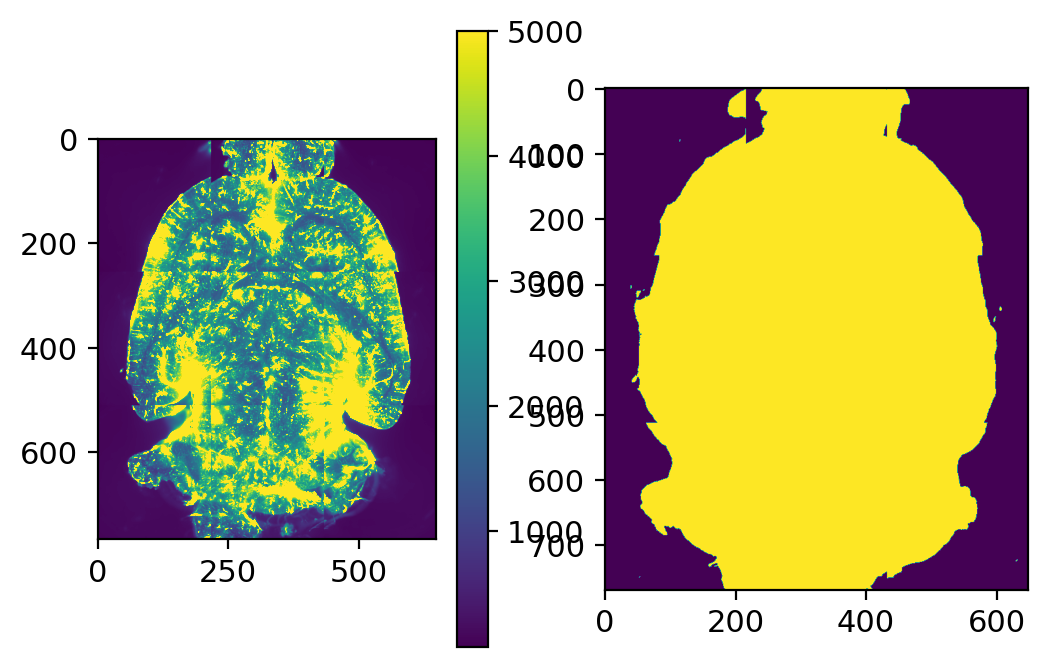

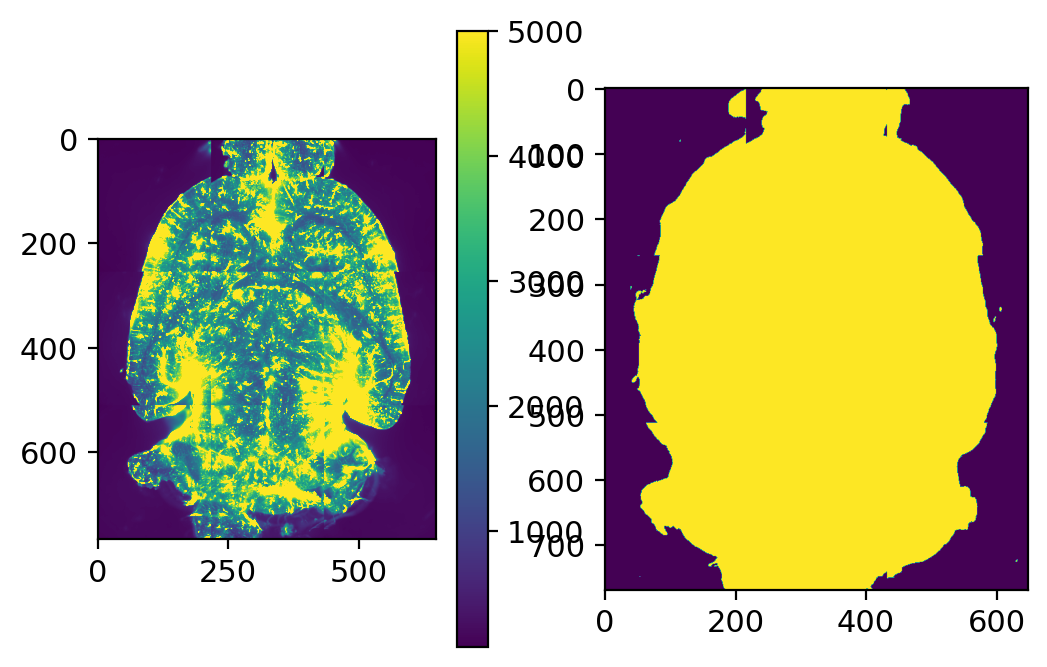

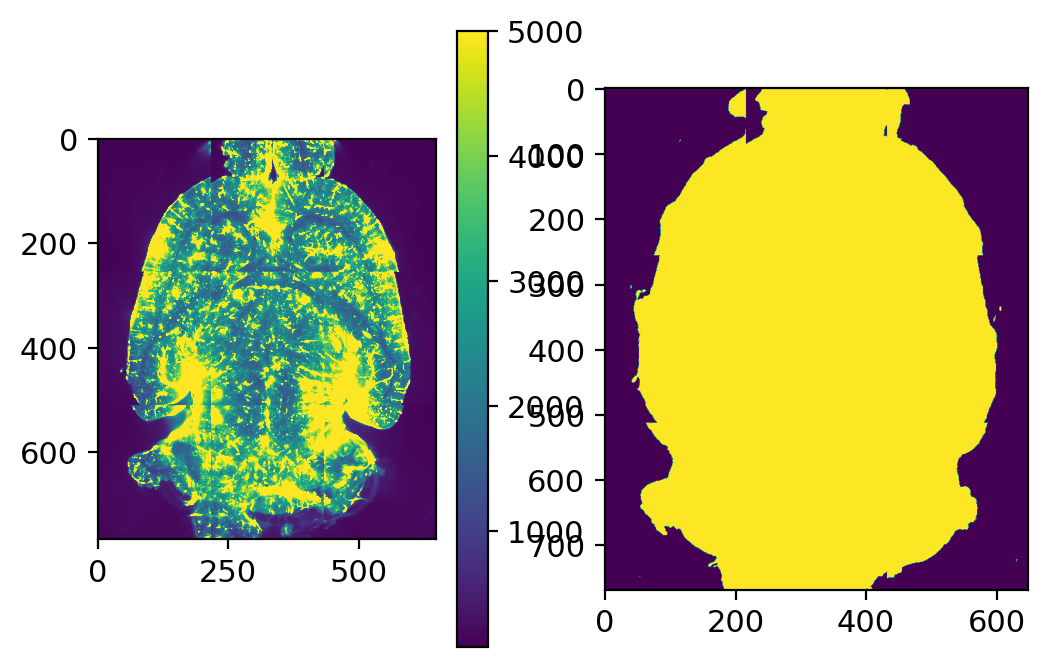

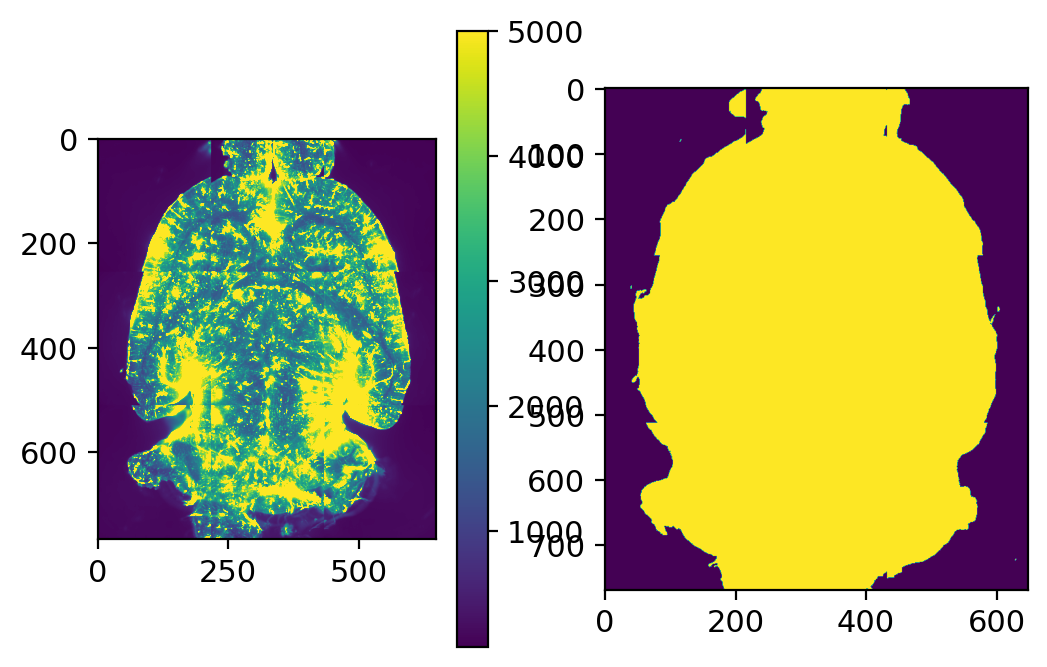

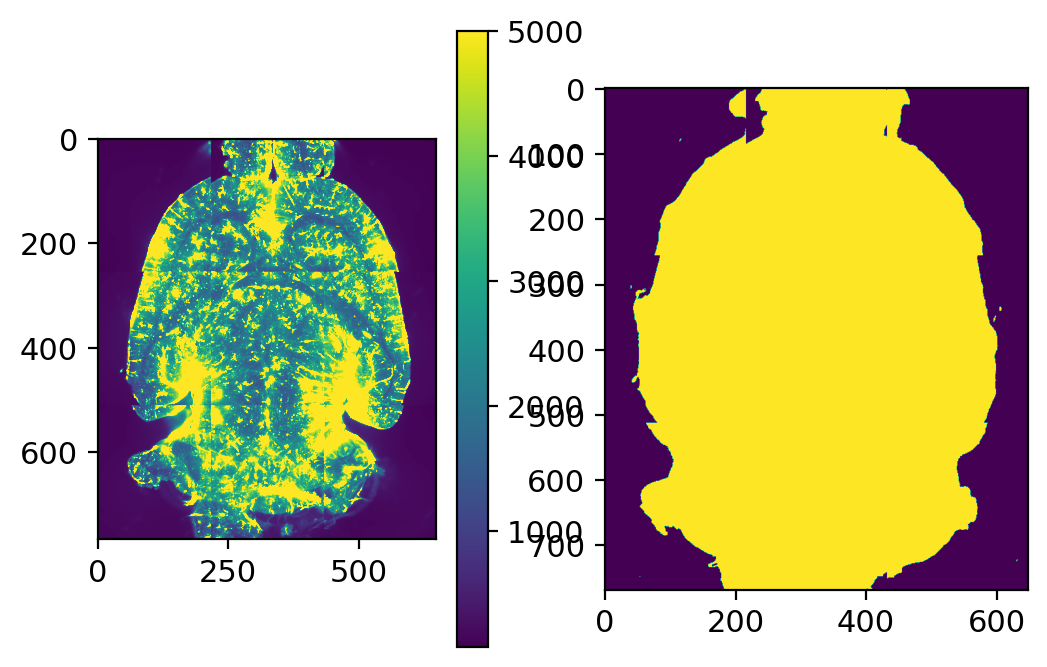

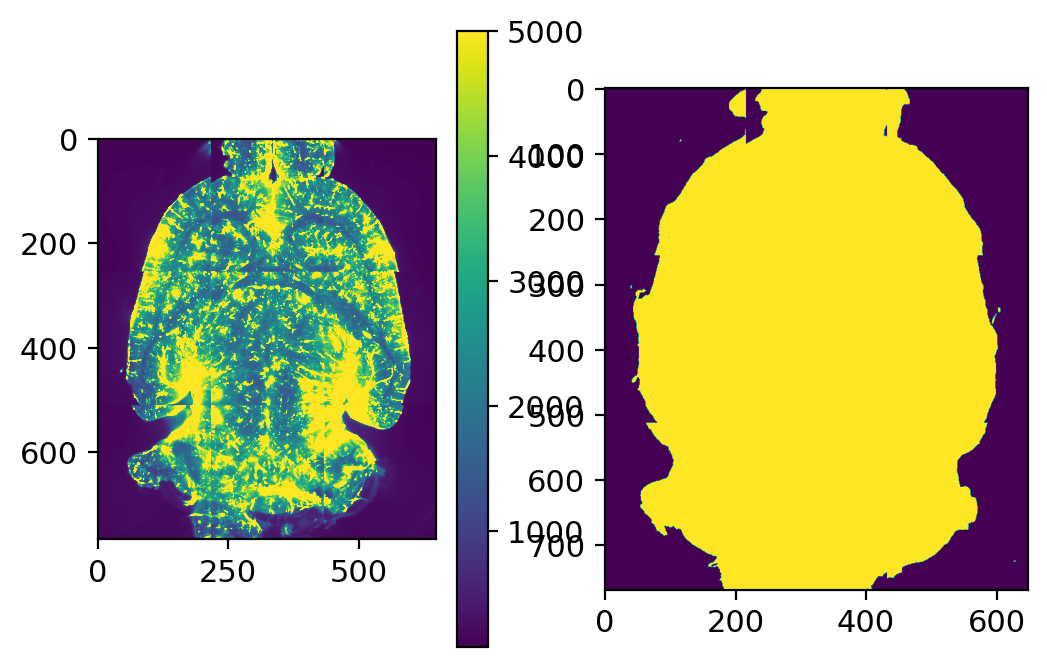

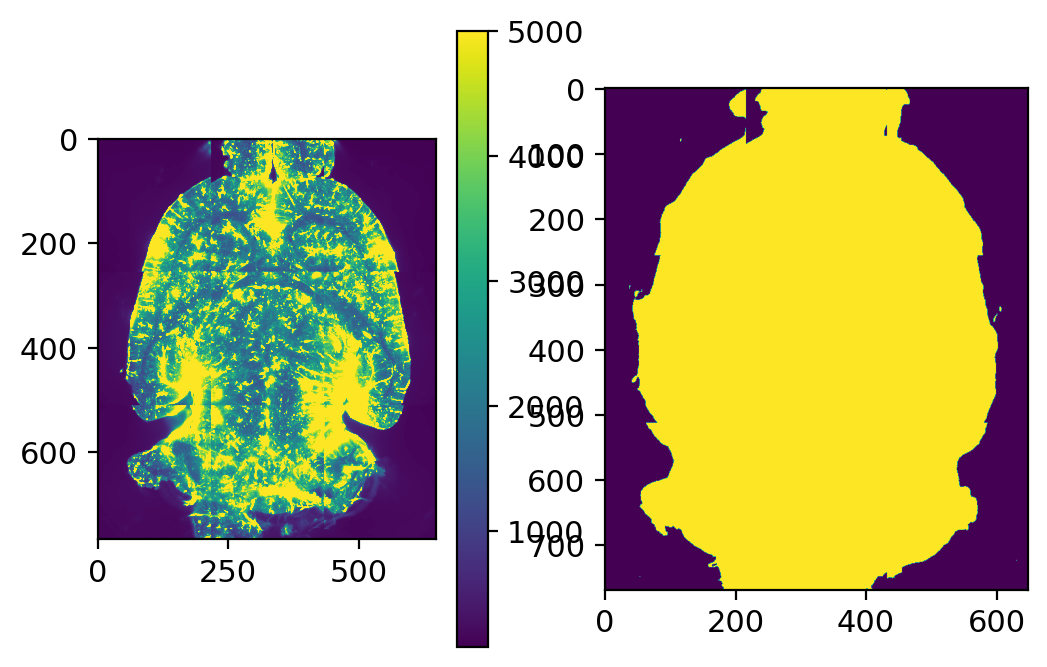

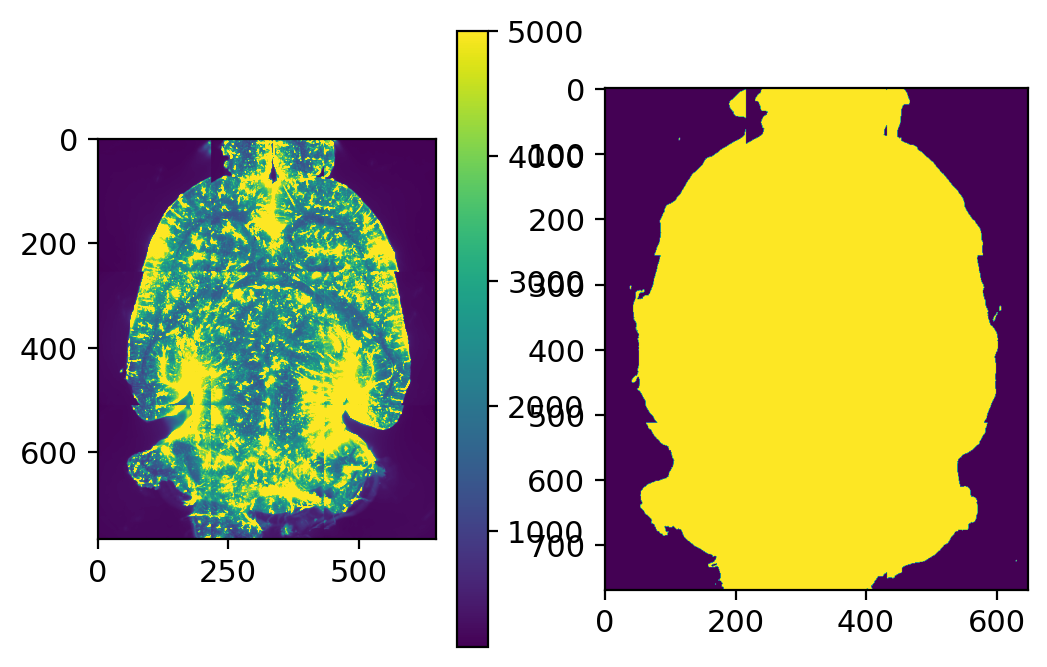

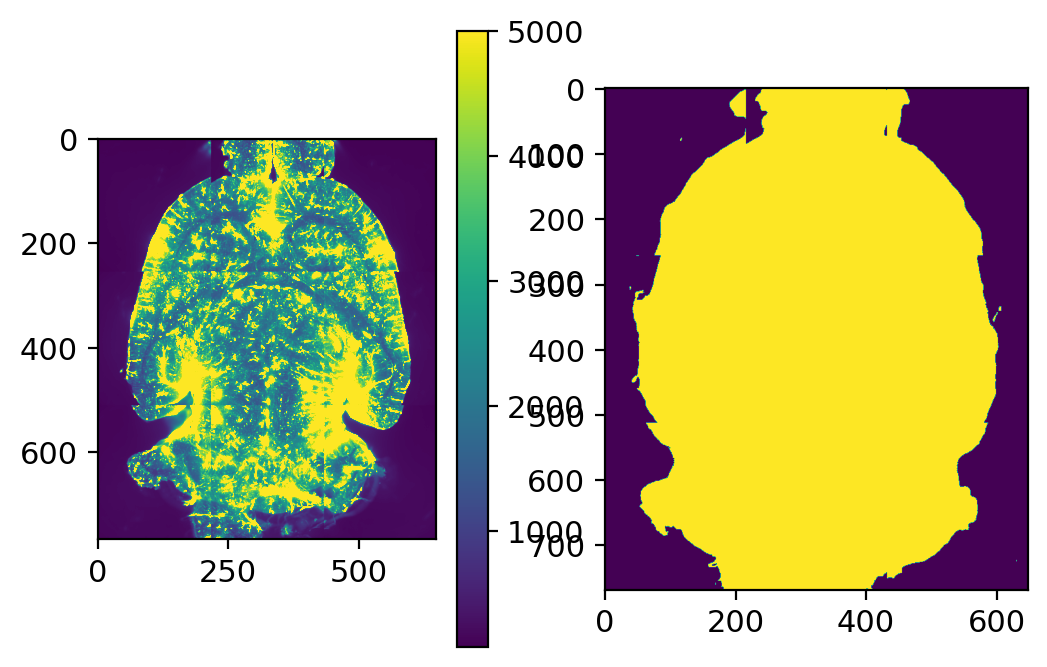

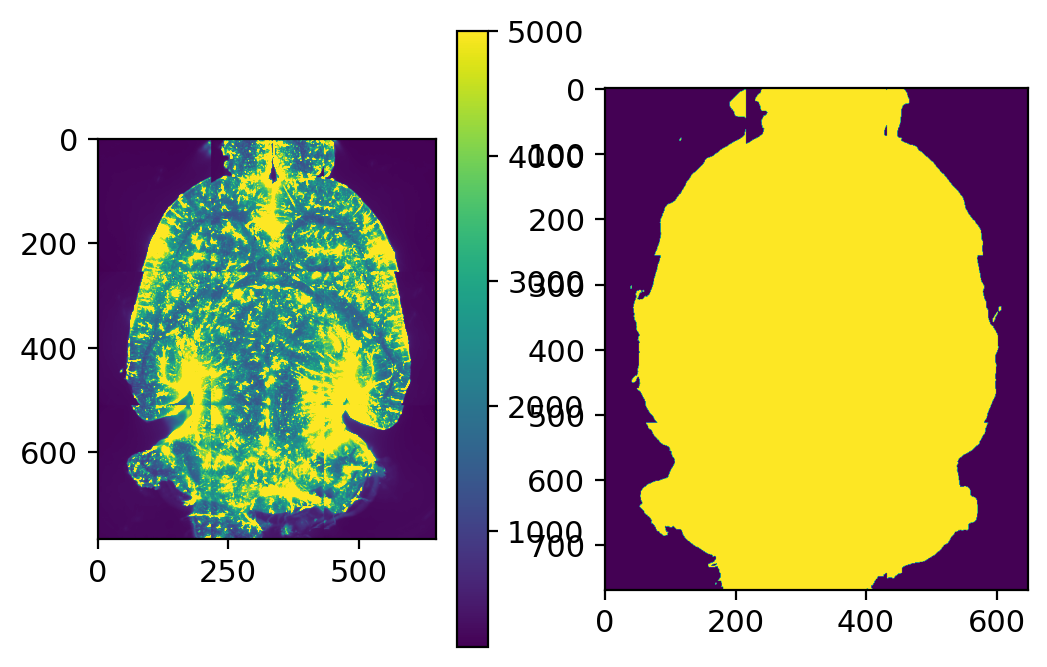

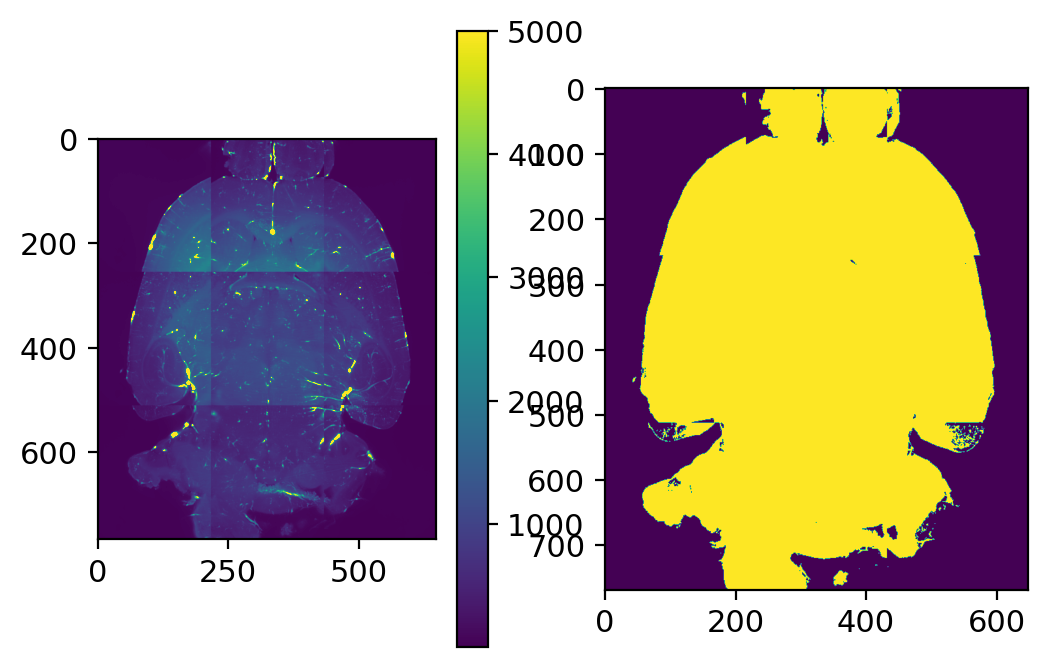

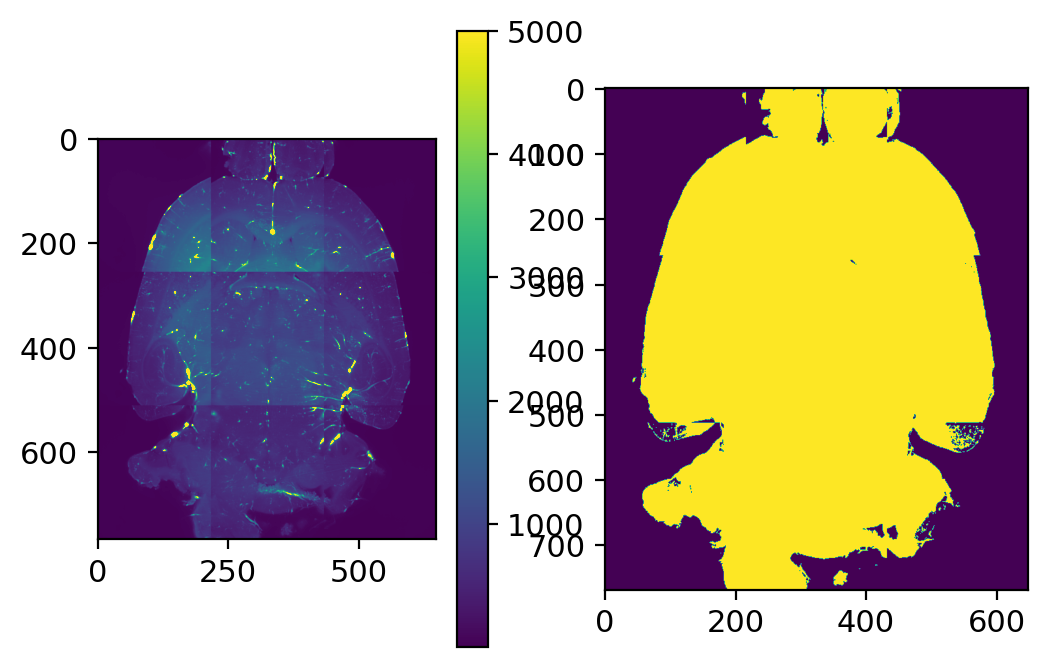

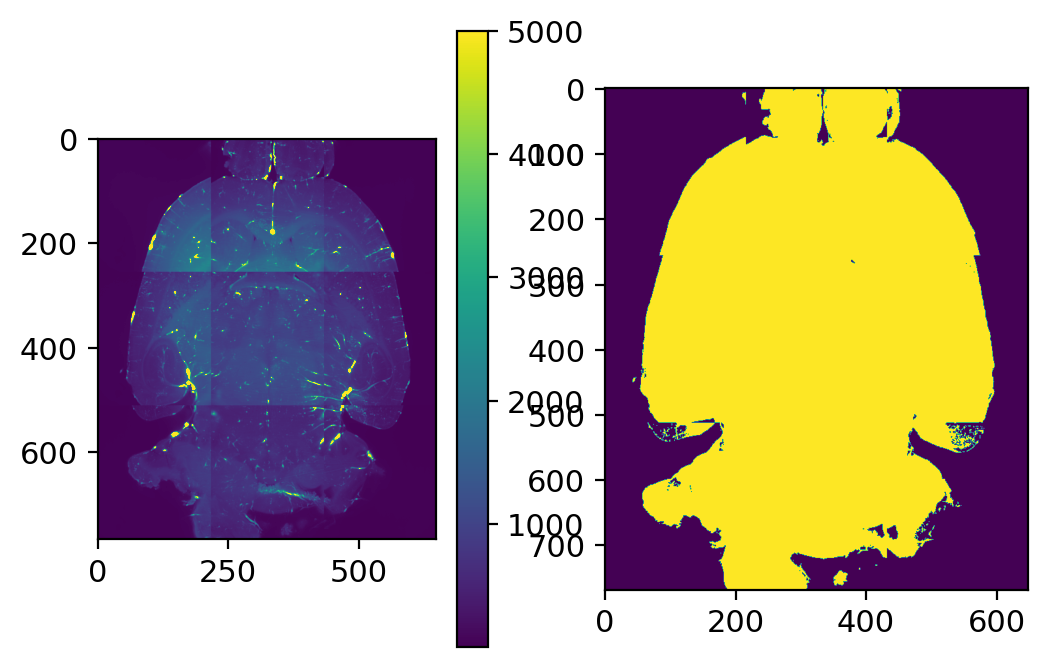

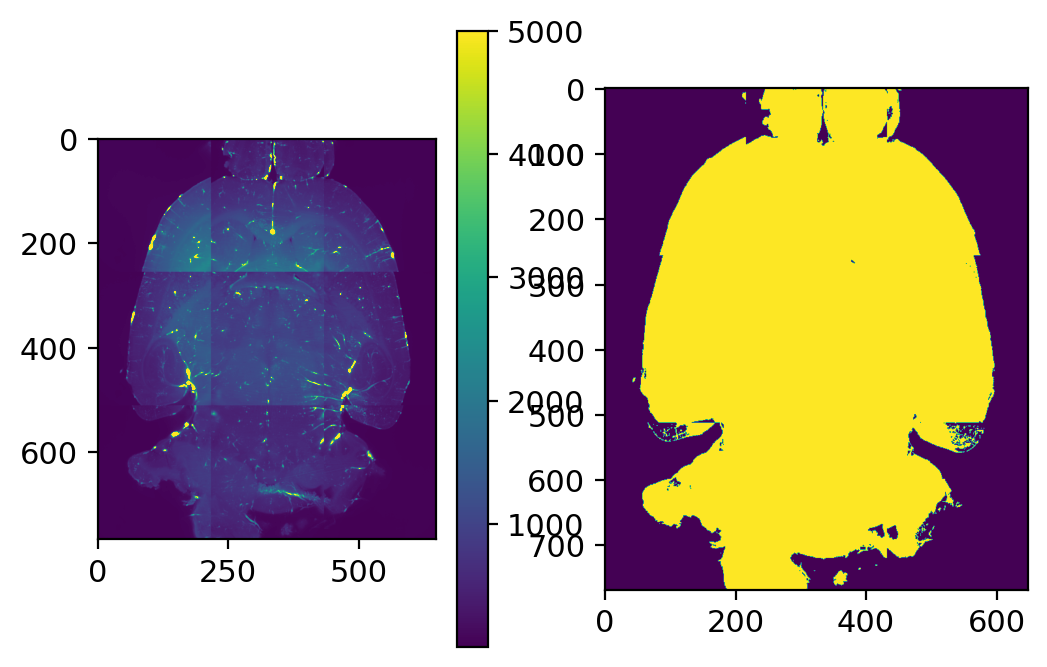

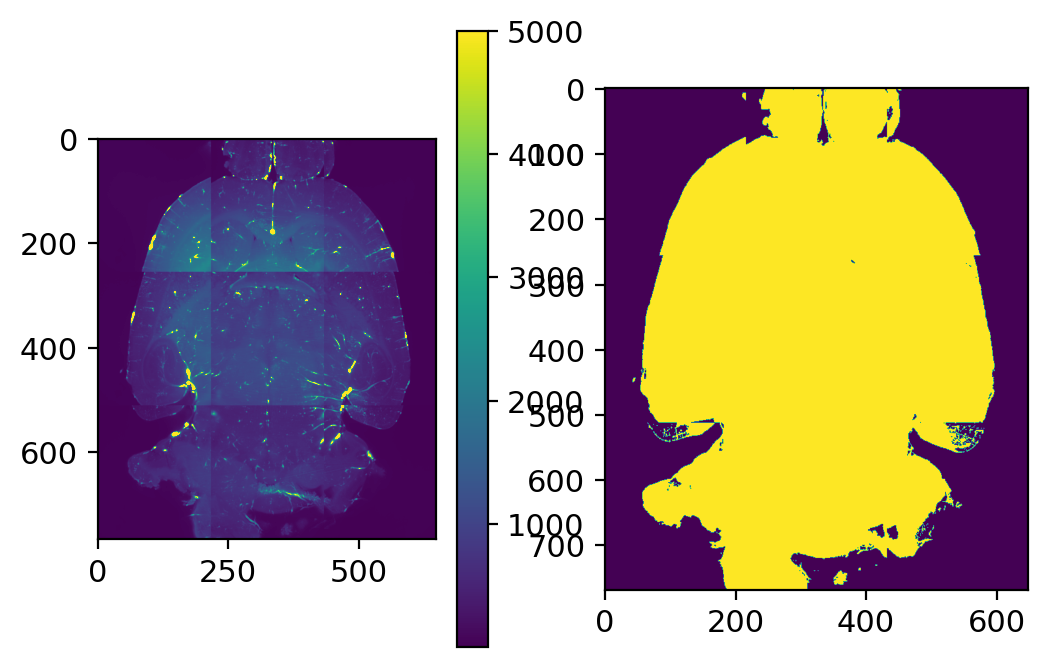

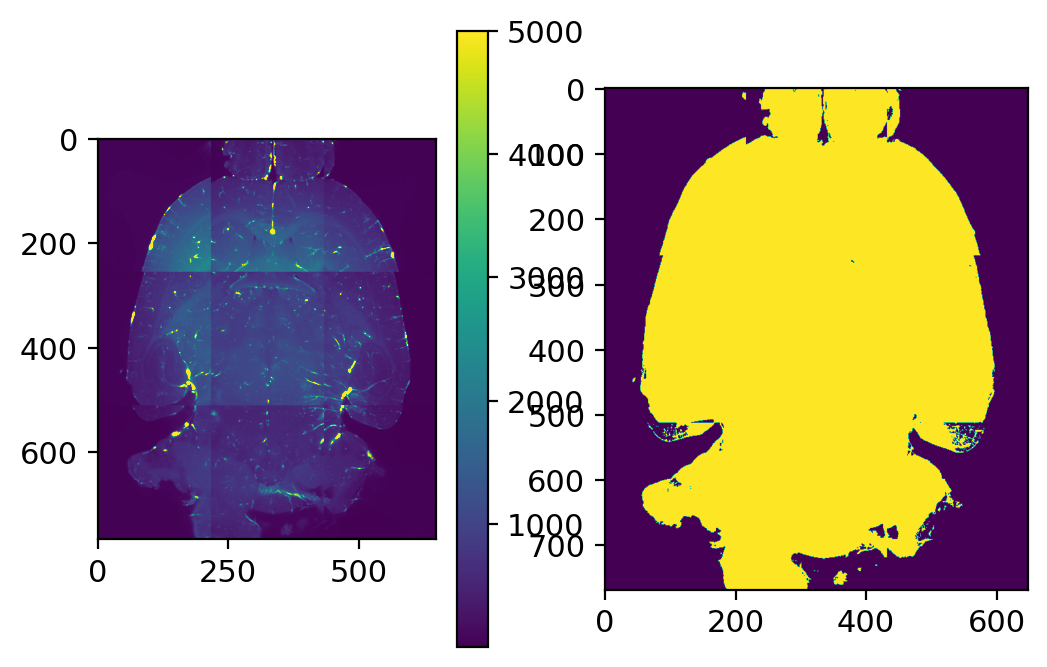

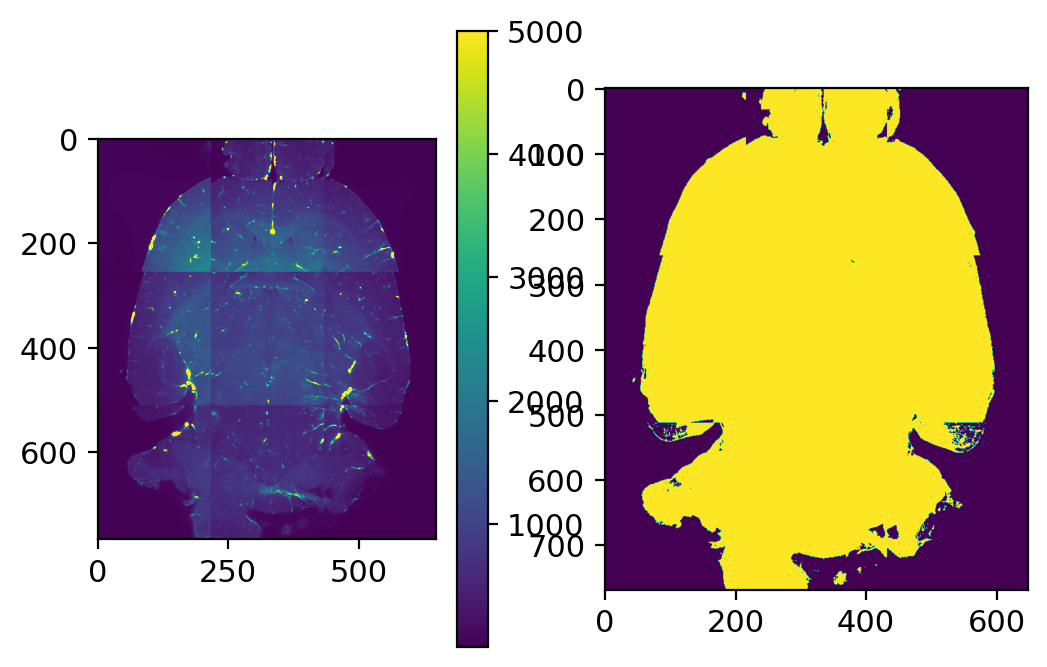

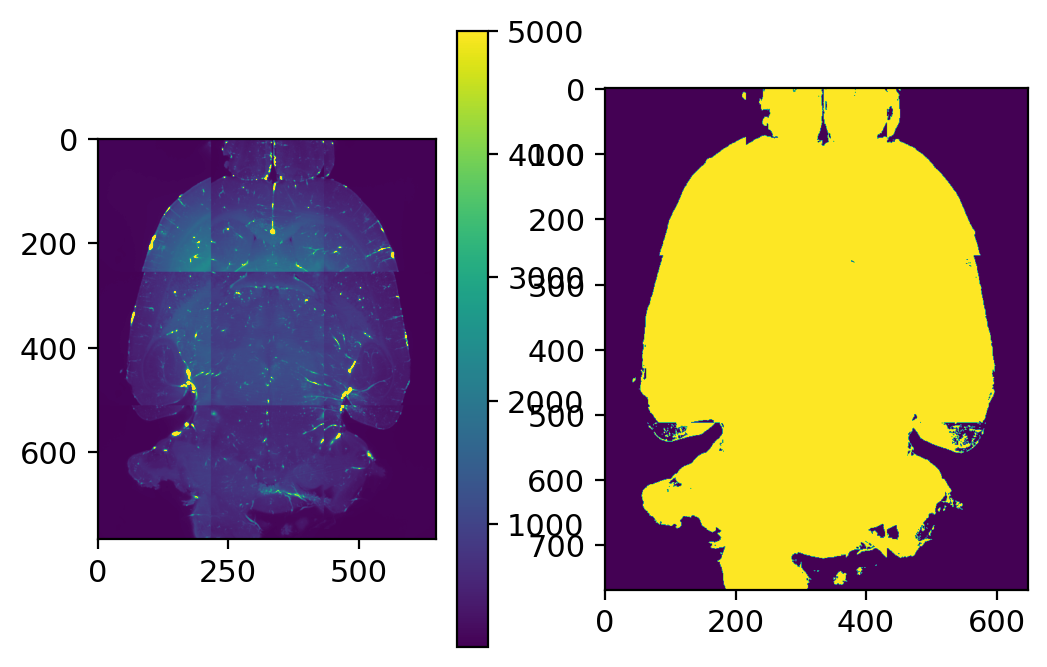

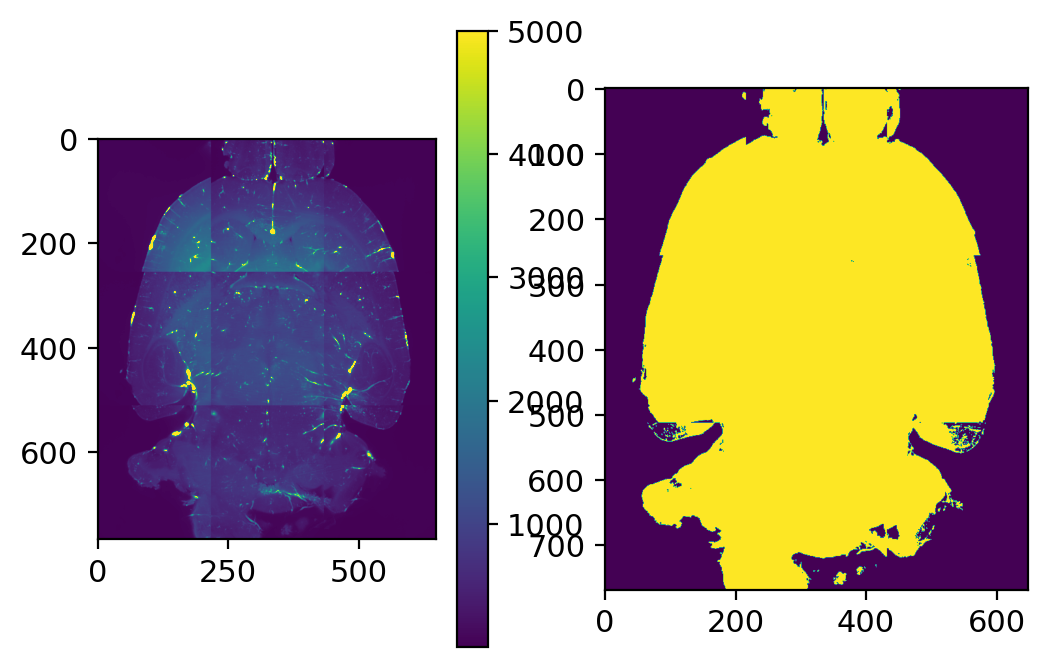

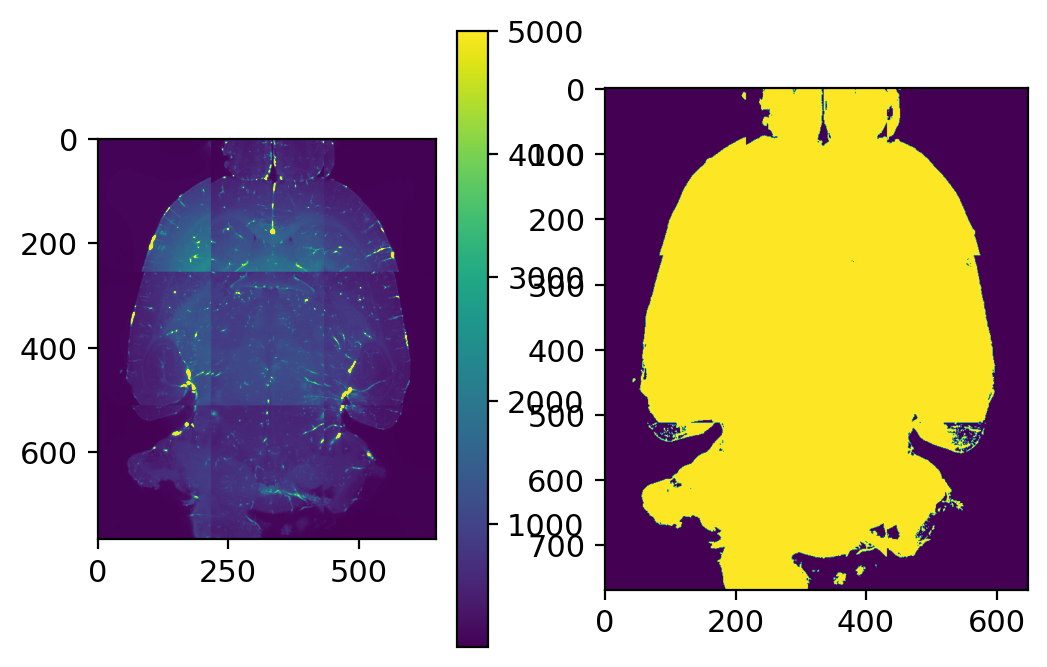

Reweighting did not converge.
Single-step optimization did not converge at the last reweighting step.
[0] fit_and_calc_entropy (Hill Climbing):   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [7]:
th = 300

for subject_path in list(image_dir.glob("CD1-42*"))[-1:]:
    print("===============", subject_path, "===============")
    image_small = np.load(subject_path / "images_small.npy")
    image2 = np.reshape(
        image_small,
        [
            image_small.shape[0],
            image_small.shape[1] * image_small.shape[2],
            *image_small.shape[3:],
        ],
    )

    weights = image2 > th

    nC, nrow, ncol, nZ, nY, nX = image_small.shape
    for c in range(image2.shape[0]):
        for z in range(nZ):
            montage = np.zeros((nrow * nY, ncol * nX))
            montage2 = np.zeros((nrow * nY, ncol * nX))
            for row in range(nrow):
                for col in range(ncol):
                    montage[
                        row * nY : (row + 1) * nY, col * nX : (col + 1) * nX
                    ] = image_small[c, row, col, z]
                    montage2[row * nY : (row + 1) * nY, col * nX : (col + 1) * nX] = (
                        image_small[c, row, col, z] > th
                    )
            plt.subplot(121)
            plt.imshow(montage, vmax=5000)
            plt.colorbar()
            plt.subplot(122)
            plt.imshow(montage2)
            plt.show()

    flatfields = []
    fitting_params = []

    for c in range(image2.shape[0]):
        params = {"channel": c, "subject_path": subject_path}
        b = BaSiC(fitting_mode="ladmap", smoothness_flatfield=0.01)
        b.autotune(
            image2[c],
            weights[c],
            search_space={
                "smoothness_flatfield": list(np.logspace(-2, 2, 20, base=10))
            },
        )
        b.fit(image2[c], weights[c])
        for z in range(nZ):
            plt.imshow(b.flatfield[z])
            plt.colorbar()
            plt.show()
        flatfields.append(b.flatfield)
        fitting_params.append({"method": "3D", **params})

        b = BaSiC(fitting_mode="ladmap", smoothness_flatfield=0.01)
        flatfield_2d = []
        for z in range(nZ):
            if z == 0:
                b.autotune(
                    image2[c, :, z],
                    weights[c, :, z],
                    search_space={
                        "smoothness_flatfield": list(np.logspace(-2, 2, 20, base=10))
                    },
                )
            b.fit(image2[c, :, z], weights[c, :, z])
            flatfield_2d.append(b.flatfield)
        flatfields.append(np.array(flatfield_2d))
        fitting_params.append({"method": "2D", **params})

    np.save(subject_path / "flatfields.npy", flatfields)
    pd.DataFrame.from_records(fitting_params).to_csv(
        subject_path / "fitting_params.csv"
    )

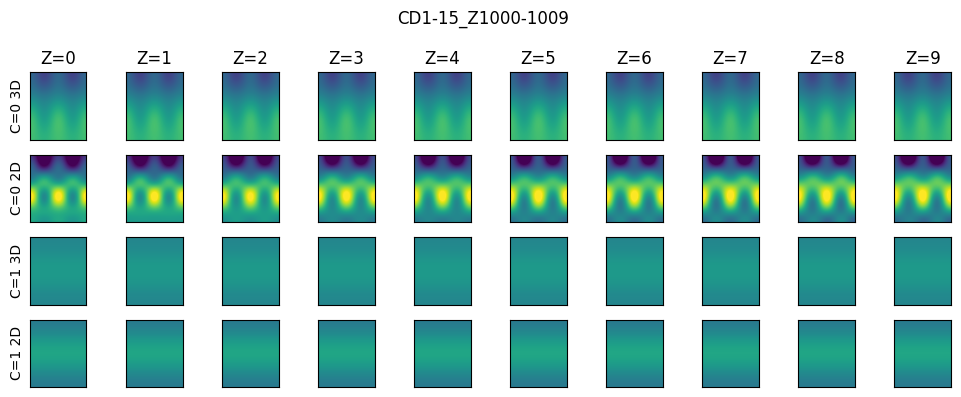

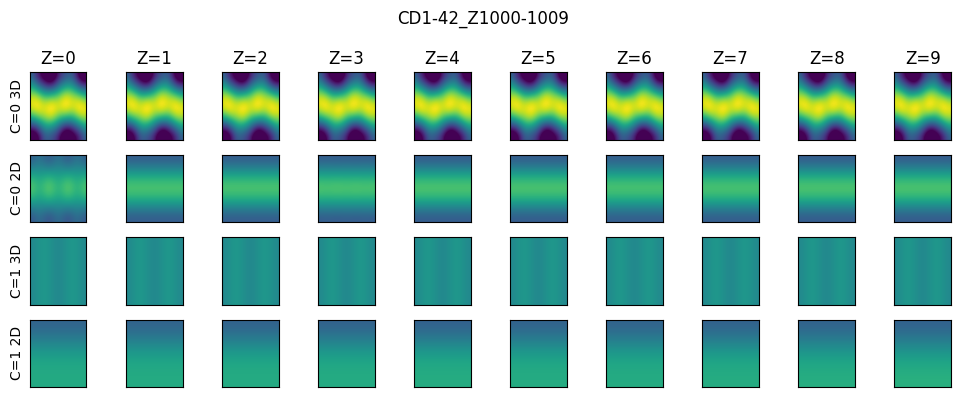

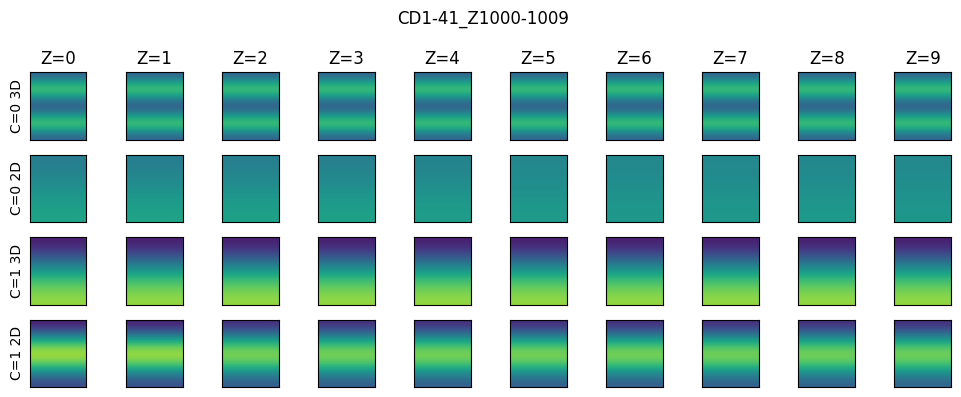

In [ ]:
for subject_path in list(image_dir.glob("CD*"))[:]:
    flatfields = np.load(subject_path / "flatfields.npy")
    fitting_params_df = pd.read_csv(subject_path / "fitting_params.csv")
    nsample, nZ = flatfields.shape[:2]
    fig, axes = plt.subplots(nsample, nZ, figsize=(nZ * 1, nsample * 1))
    for s in range(nsample):
        for z in range(nZ):
            axes[s, z].imshow(flatfields[s, z], vmin=0.9, vmax=1.1)
            axes[s, z].set_xticks([])
            axes[s, z].set_yticks([])
            if z == 0:
                row = fitting_params_df.iloc[s]
                axes[s, z].set_ylabel(f"C={row['channel']} {row['method']}")
            if s == 0:
                axes[s, z].set_title(f"Z={z}")
    fig.suptitle(subject_path.name)
    fig.tight_layout()
    fig.show()

In [ ]:
list(subject_path.glob("*.npy"))

[PosixPath('/content/drive/MyDrive/Colab Notebooks/BaSiCPy/3DLightsheetfromAli/mouse_brain_raw_scans/CD1-41_Z1000-1009/images.npy'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/BaSiCPy/3DLightsheetfromAli/mouse_brain_raw_scans/CD1-41_Z1000-1009/images_small.npy')]

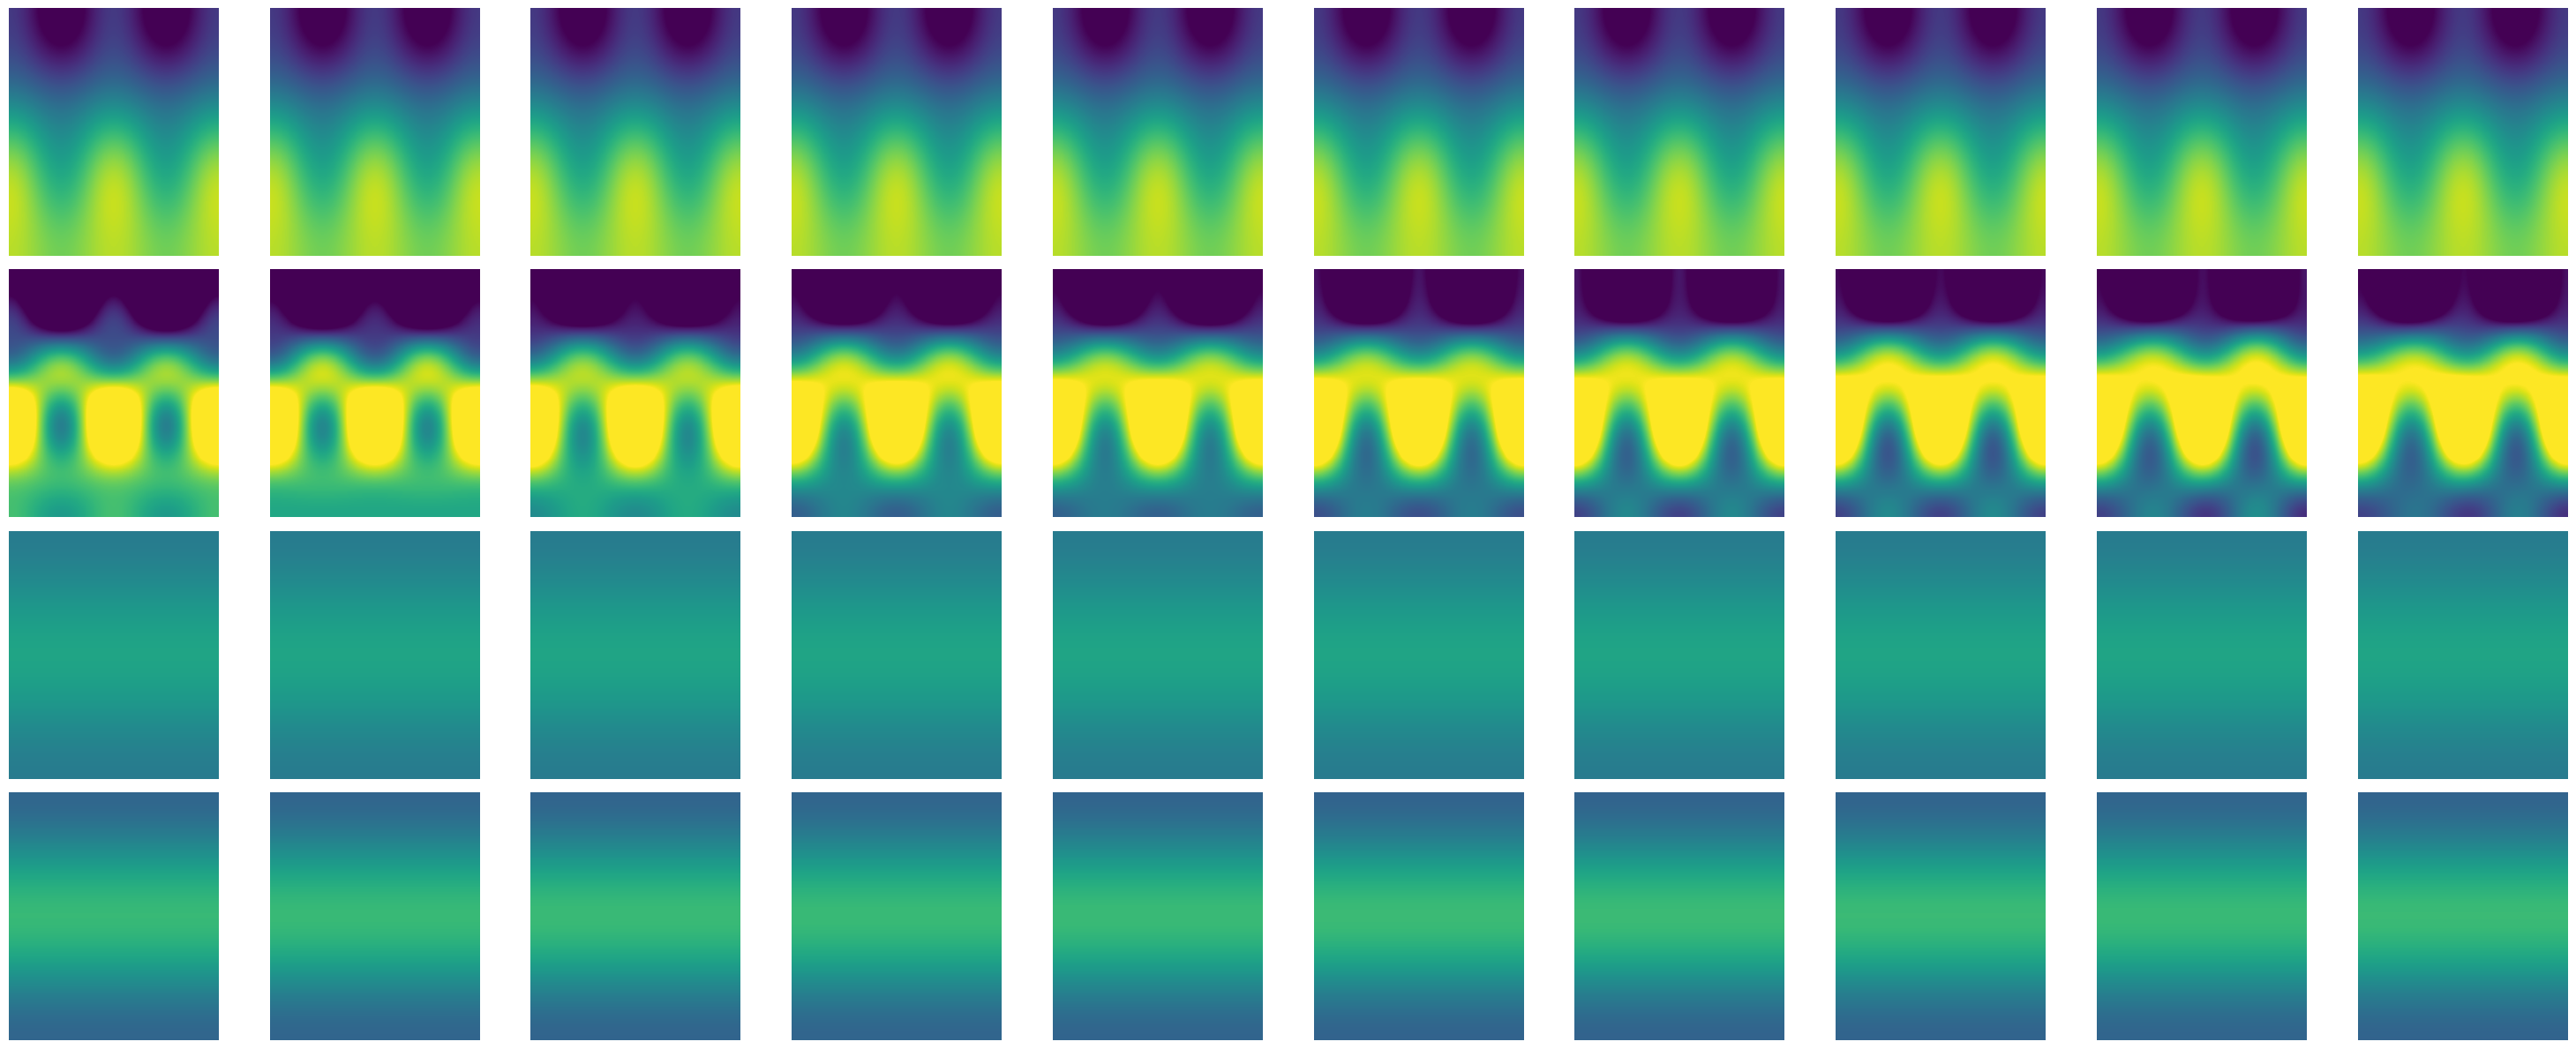